# Project - Retail Product classification

## Preparation


### Import the Data from Kaggle

In [1]:
#Mount google drive to save/load weigths 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
! pip install -q kaggle
from google.colab import files
print("Choose the kaggel.jason file on your computer")
files.upload() 

Choose the kaggel.jason file on your computer


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"markusobert","key":"bf8bdd6dd36b298ff3651198bb29ffab"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list
! pip install --upgrade --force-reinstall --no-deps kaggle
# Download of the data from kaggle
! kaggle competitions download -c retail-products-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
retail-products-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Create a directory and unzip the files there
! mkdir retail-products-classification
! unzip retail-products-classification.zip -d retail-products-classification &> /dev/null

mkdir: cannot create directory ‘retail-products-classification’: File exists


### Importing the necessary libraries

In [5]:
!pip install keras_metrics &> /dev/null
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_english=set(stopwords.words('english'))
from gensim.models.wrappers import FastText
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#import cv2
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline

#self importeted stuff
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### List of classes
This is the List of the 21 classes in wich the products have to be categorize

In [6]:
CATEGORIES = ['Electronics', 
              'Sports & Outdoors',
              'Cell Phones & Accessories',
              'Automotive',
              'Toys & Games',
              'Tools & Home Improvement', 
              'Health & Personal Care', 
              'Beauty',
              'Grocery & Gourmet Food', 
              'Office Products',
              'Arts, Crafts & Sewing',
              'Pet Supplies', 
              'Patio, Lawn & Garden',
              'Clothing, Shoes & Jewelry', 
              'Baby',
              'Musical Instruments',
              'Industrial & Scientific', 
              'Baby Products',
              'Appliances',
              'All Beauty',
              'All Electronics']

## Exploratory Data Analytics


*   Visualize
*   Pre-process
*   clean



### Analysis of the product description


#### Read the train.csv file

In [7]:
data = pd.read_csv('retail-products-classification/train.csv')
#pid = list(data['ImgId'])
#descriptions = list(data['description'])
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


#### Distribution of samples in each categories
First have a look how the data is distributed. In this case the data is nearly equally distributed

In [8]:
#data['categories'].value_counts().plot(kind='bar', figsize=(14, 3));
data['categories'].value_counts()

Arts, Crafts & Sewing        2225
Beauty                       2202
Grocery & Gourmet Food       2201
Sports & Outdoors            2201
Automotive                   2200
Baby Products                2200
Cell Phones & Accessories    2200
Baby                         2200
Tools & Home Improvement     2200
Pet Supplies                 2200
Health & Personal Care       2200
Industrial & Scientific      2200
Clothing, Shoes & Jewelry    2200
Office Products              2200
Electronics                  2200
All Beauty                   2200
Appliances                   2200
Patio, Lawn & Garden         2200
All Electronics              2200
Toys & Games                 2200
Musical Instruments          2200
Name: categories, dtype: int64

#### Characters in the title and the description
Have a look at the size of the distribution of the description length. In the Histogramm you can see the most Descriptions have not more than 5000 characters. But there are also some outliers with a lot of more chrachters up to 20000.

Text(0.5, 1.0, 'Characters in the description')

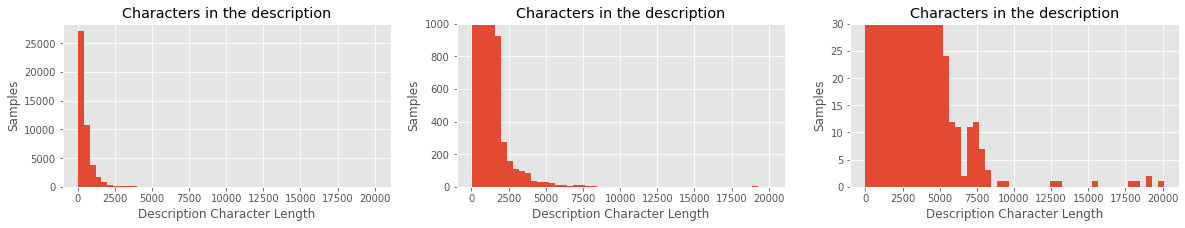

In [9]:
#get the number of characters
char_num=data['description'].str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(char_num, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('Description Character Length')
axes[0].set_title('Characters in the description')

axes[1].hist(char_num, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('Description Character Length')
axes[1].set_title('Characters in the description')

axes[2].hist(char_num, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('Description Character Length')
axes[2].set_title('Characters in the description')

When you have a look at the description with the most characters you can see there is a lot of trash in the description. Maybe some html code or something different. So for classification we have to drop the trash of the description. To simplify just use the head of the description.

In [10]:
#Description with the most words
data['description'].iloc[char_num.argmax()]

'Turbo.264 HD Video Encoder &amp; AcceleratorConvert HD video to the universal H.264 formatThe Turbo.264 HD is a USB hardware device and accompanying Mac software that works together to dramatically accelerate the conversion of video to H.264 format.H.264 video is a universal format that can be played on iPod, iPhone, Apple TV, gaming consoles, YouTube, and much more.The Turbo.264 HD accepts nearly any video file and outputs high quality H.264 video, in formats up to full 1080P HD.[if gte mso 9]><xml> <w:WordDocument> <w:View>Normal</w:View> <w:Zoom>0</w:Zoom> <w:TrackMoves  /> <w:TrackFormatting  /> <w:PunctuationKerning  /> <w:ValidateAgainstSchemas  /> <w:SaveIfXMLInvalid>false</w:SaveIfXMLInvalid> <w:IgnoreMixedContent>false</w:IgnoreMixedContent> <w:AlwaysShowPlaceholderText>false</w:AlwaysShowPlaceholderText> <w:DoNotPromoteQF  /> <w:LidThemeOther>EN-US</w:LidThemeOther> <w:LidThemeAsian>X-NONE</w:LidThemeAsian> <w:LidThemeComplexScript>X-NONE</w:LidThemeComplexScript> <w:Compati

Also you can see there are 1042 articel without any description (NaN) and one articel with no title.

In [11]:
#count the NaN values
print(data['description'].isnull().sum())
print(data['title'].isnull().sum())
print(data['ImgId'].isnull().sum())
print(data['categories'].isnull().sum())

1042
1
0
0


Later one can combine the title and the description so that there will be enough characters/words for description. But first have a look if they are all of a specific categorie. So when we drop all the products with no description the datset of the classes "Automotive" and "Industrial and Scientific" will be reduce by nearly 10 %

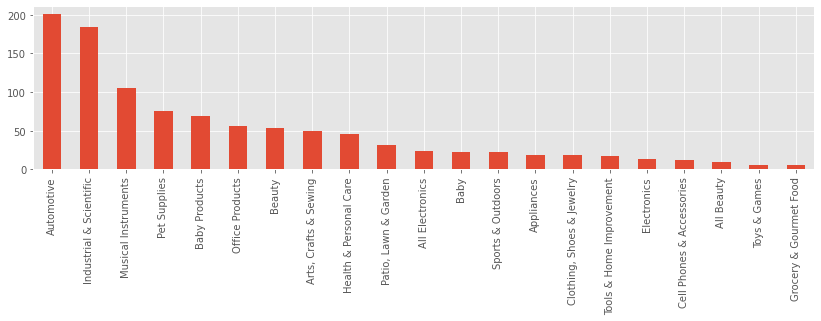

In [12]:
#Distribution of the nan values in the discription in the different categories
#Get the categories of the products where de description is nan
data_nodescrip=data[data['description'].isnull()]
data_nodescrip['categories'].value_counts().plot(kind='bar', figsize=(14, 3));

Now also have a look to the number of characters in the title. So there are also a few products with a pretty long title. But the most title have less then 100 characters.

Text(0.5, 1.0, 'Characters in the title')

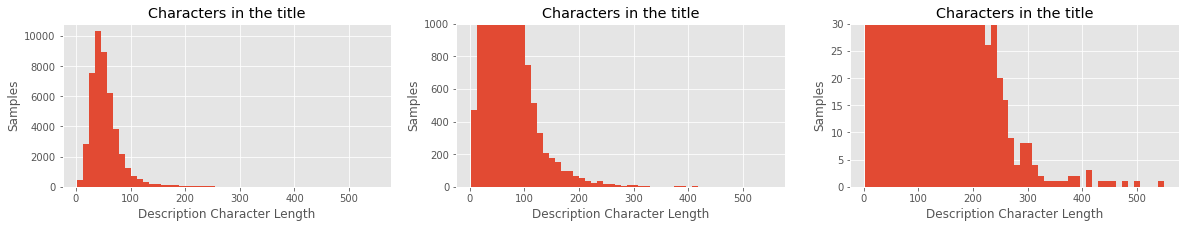

In [13]:
char_num_title=data['title'].str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(char_num_title, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('Description Character Length')
axes[0].set_title('Characters in the title')

axes[1].hist(char_num_title, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('Description Character Length')
axes[1].set_title('Characters in the title')

axes[2].hist(char_num_title, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('Description Character Length')
axes[2].set_title('Characters in the title')

In [14]:
#Title with the most words
data['description'].iloc[char_num_title.argmax()]

'Heavy Duty Luxurious Pashmina Shawl, Wrap And Scarf - Perfect Accessory For Any Seasons, Event or Occasion! You Will Feel So Great Due To This Pashmina Wool is The Finest Cashmere From Inner Mongolia-High Mountain Goat Fur,The Most Soft Wool. All Natural With No Any Imitation or Man Made Materials. Heavy Duty With Soft Touch,Look Fashionable & Stylish , Perfect Size at 27" Width x 70" Length + 3" x 2 Fringe ,Good for Your Wrap ,Shawl and Scarf . A Perfect Item For Christmas Gifts or Birthday Gifts , Super Saving,100% Satisfaction Guaranteed'

In [15]:
#Check for titles with only a few characters in the title
data_short_title=data[data['title'].str.len()<5]
print("Number of titels with less then 5 characters:  ", data_short_title['title'].count())
data_short_title

Number of titels with less then 5 characters:   7


,ImgId,title,description,categories
5591,1934857602,Poo,It&#x2019;s been a tough day in the monkey cag...,Toys & Games
7470,291484980X,Evo,The island of Krah is home to nomadic tribes a...,Toys & Games
20054,B0000T16L8,Rolo,"Two great flavors in one, ROLO candy is made u...",Grocery & Gourmet Food
24275,B00012NBZS,DHEA,"Vitamin Shoppe Dhea, 50 mg, 100 capsules",Health & Personal Care
33614,B0000CA2RD,Zori,Sandals made of straw weave patterns. Black tr...,Sports & Outdoors
34082,B000HLDCUW,Aida,Myto 2MCD 064.333. Original 2006 MYTO pressing.,"Arts, Crafts & Sewing"
35538,B00000IWD6,Rook,"With its numbered deck of 57 cards, Rook, the ...",Toys & Games


#### Words in the title and the description
Have a look at the size of the distribution of the number of words. In the Histogramm you can see the most Descriptions have not more than 250words.

Text(0.5, 1.0, 'Words in the description')

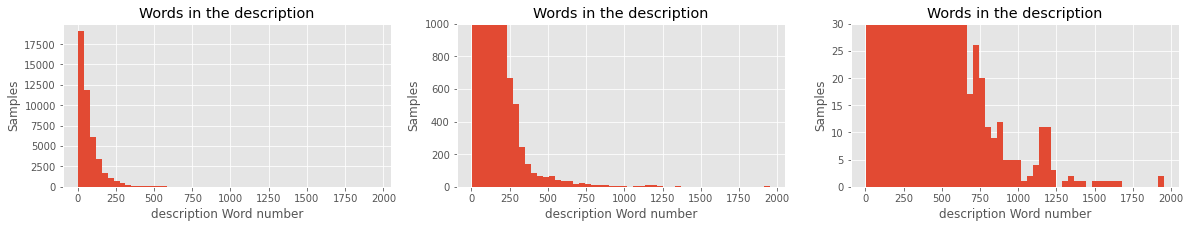

In [16]:
#calculate hte number of words
word_num=data['description'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(word_num, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('description Word number')
axes[0].set_title('Words in the description')

axes[1].hist(word_num, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('description Word number')
axes[1].set_title('Words in the description')

axes[2].hist(word_num, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('description Word number')
axes[2].set_title('Words in the description')

In the title there are most of the time less then 20 words

Text(0.5, 1.0, 'Words in the title')

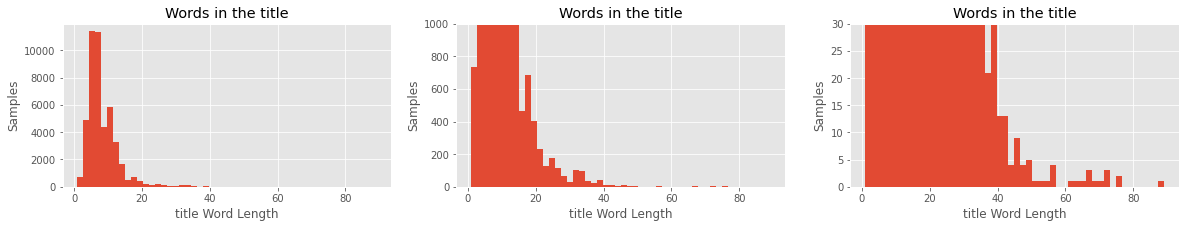

In [17]:
word_num_title=data['title'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(word_num_title, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('title Word Length')
axes[0].set_title('Words in the title')

axes[1].hist(word_num_title, bins=50)
axes[1].set_ylim([0, 1000])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('title Word Length')
axes[1].set_title('Words in the title')

axes[2].hist(word_num_title, bins=50)
axes[2].set_ylim([0, 30])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('title Word Length')
axes[2].set_title('Words in the title')

#### Merge title and description
In above analysis one can see there are a few products without any description, a few with a very short title and so on. Because of this you should combine the title and the description of the products.

In [18]:
#Creating pandas dataframe with merged description
data_merge = pd.DataFrame({'ImgId':data['ImgId'],
                        'description':data['title']+" "+data['description'],
                        'categories':data['categories']})
data_merge.head()

,ImgId,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE Solder Pick f...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T6...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light This twoway light featu...,Health & Personal Care


#### Number of words in merged description
One can see there are a few merged descriptions with just a few words. But there is no description without words

Text(0.5, 1.0, 'Words in the description')

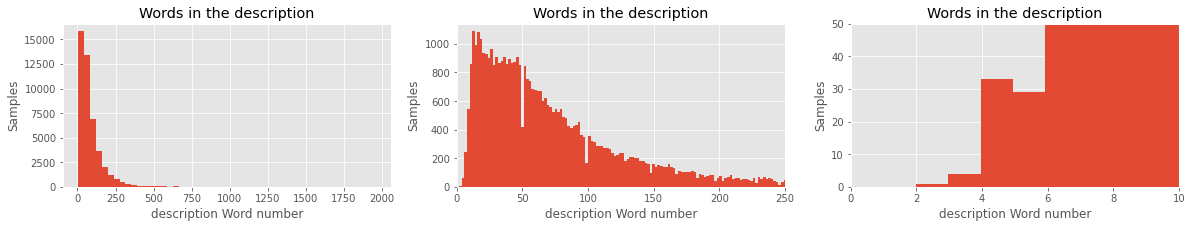

In [19]:
#calculate hte number of words
word_num=data_merge['description'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(20,3))

axes[0].hist(word_num, bins=50)
axes[0].set_ylabel('Samples')
axes[0].set_xlabel('description Word number')
axes[0].set_title('Words in the description')

axes[1].hist(word_num, bins=1000)
axes[1].set_xlim([0, 250])
axes[1].set_ylabel('Samples')
axes[1].set_xlabel('description Word number')
axes[1].set_title('Words in the description')

axes[2].hist(word_num, bins=2000)
axes[2].set_ylim([0, 50])
axes[2].set_xlim([0, 10])
axes[2].set_ylabel('Samples')
axes[2].set_xlabel('description Word number')
axes[2].set_title('Words in the description')

Look for a few examples with less words, how good the product description of them is.
One can see there some times the same words in the title and in the description. Furthermore there are one word who describes the product and the other word is a brand name

In [20]:
#Check for descriptions with only a few words in it
data_short_title=data_merge[data_merge['description'].str.split().str.len()<5]
print("Number of titels with less then 5 Words:  ", data_short_title['description'].count())
data_short_title

Number of titels with less then 5 Words:   38


,ImgId,description,categories
791,B0000AL2UC,Nokia 8310 Nokia 8310,Cell Phones & Accessories
912,B0000AVBE4,Athletic Cup Cup only.,Sports & Outdoors
3261,B0000BWBNY,Lindy Marker Buoy .,Sports & Outdoors
3506,B0000CEFOF,Tiger-Dragon Patch Tiger-Dragon Patch,Sports & Outdoors
4619,B001HSEEB0,Bosch 475225 PANEL-FACIA PANEL-FACIA,Appliances
5738,B000E438LA,Check/Anti-siphon Valve Err:509,Industrial & Scientific
5794,B0000VLRBK,Amaretto Oil Amaretto Oil,Grocery & Gourmet Food
7377,B0002QTHR4,Water Dancers Water dancers,Automotive
8884,B0001J2NDW,"COCOA,STARBUCKS,GOUR,24BX COCOA,STARBUCKS,GOUR...",Grocery & Gourmet Food
12181,B00294KXKW,"Frigidaire FGHD2433K, Black Dishwashers",Appliances


#### Clean descriptions

To get just the important words out of the description. Firstly they will be filtered so that the following stuff is out of the description: 

*   all characters will be converted to small one
*   delete special characters '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
*   Words with less then 2 characters
*   english stop words (e.g. about above all an for few ....) 
*   use only the first 250 words


In [153]:
#manual filtering of the descriptions
def filter_description (text_data):
    # extract numbers and special characters
    # convert all characters to lower
    data_words = tf.keras.preprocessing.text.text_to_word_sequence(
          text_data,
          filters='!"#$%&()*+,-./:;\<=>?@[\\]^_`{|}~\t\n1234567890',
          lower=True,
          split=' ' 
        )
    #filter short words with less then 2 characters
    data_words = [i for i in data_words if(len(i) > 2)]
    # Remove stop words
    data_words = [s for s in data_words if s not in stop_english]
    #Just use the first 250 Words of the description
    del data_words[256:]


    # using list comprehension
listToStr = ' '.join(map(str, data_filtered[1]))
print(listToStr) 
    #put the strings together
    filters="',"
    data_words
    for x in range(len(filters)):
        data_words= data_words.replace(filters[x],"")
    #return data_words  
    return str(data_words) 

In [147]:
#manual filtering of the descriptions
def filter_description (text_data):
    # extract numbers and special characters
    # convert all characters to lower
    filters='!"#$%&()*+,-./:;\<=>?@[\\]^_`{|}~\t\n1234567890'
    for x in range(len(filters)):
        data_words= text_data.replace(filters[x],"")
    #filter short words with less then 2 characters
    data_words = [i for i in data_words if(len(i) > 2)]
    # Remove stop words
    data_words = [s for s in data_words if s not in stop_english]
    #Just use the first 250 Words of the description
    del data_words[256:]
    #return data_words  
    return data_words 

In [154]:
#just for debugging to get the raw dataset again
del data
del data_filtered
del data_merge
data = pd.read_csv('retail-products-classification/train.csv')

In [155]:
#Creating pandas dataframe with merged description
data_merge = pd.DataFrame({'ImgId':data['ImgId'],
                        'description':data['title']+" "+data['description'],
                        'categories':data['categories']})

In [156]:
data_filtered = []
#filter every description with the above functions
for i in range(0,data_merge.shape[0]):
    data_filtered.append(filter_description(str(data_merge['description'].iloc[i])))



AttributeError: ignored

In [151]:
#here are exmaples of how the text got filtered
n=2
for n in range(3):
    n = n *42
    print(data_merge['description'].iloc[n])
    print(data_filtered[n])
    print("")

TUNGSTEN SOLDER PICK WITH HANDLE Solder Pick for picking up molten solder when making jewelry
[]

18mm x 1.5 High Speed Steel Plug Tap High Speed Steel. Plug Style (most common hand tap). Ground Thread.
[]

Celltronix Universal Rechargeable Dual USB Portable Power Pack A UNIVERSAL backup power solution for all your devices!* 4000mA gives enough power for extended use or higher power devices* Up to 8x more battery life for some devices!* 2 USB ports allow you to charge 2 USB devices at the same time* Includes adapters for the most popular electronic devices (including micro USB mini USB and iPod/iPhone 3G)* Charge the internal battery with included AC DC and USB chargers
[]



In [132]:
data_filtered[1][1]


"'"

In [126]:
# using list comprehension
listToStr = ' '.join(map(str, data_filtered[1]))
print(listToStr) 

# using list comprehension
listToStr = ' '.join([str(elem) for elem in data_filtered[1]])
print(listToStr) 

[ ' w r i t e ' ,   ' r i g h t ' ,   ' s c r e e n ' ,   ' p r o t e c t o r ' ,   ' s o n y ' ,   ' s c r e e n ' ,   ' n e e d ' ,   ' p r o t e c t ' ,   ' s c r e e n s ' ,   ' e x p e n s i v e ' ,   ' l i t t l e ' ,   ' g a d g e t r y ' ,   ' p a c k ' ,   ' c l e a r ' ,   ' s c r e e n ' ,   ' p r o t e c t o r s ' ,   ' g e n e r o u s ' ,   ' t h i c k ' ,   ' p r o t e c t ' ,   ' s c r a t c h e s ' ,   ' r e d u c e ' ,   ' g l a r e ' ,   ' m a d e ' ,   ' s o n y ' ,   ' c l i ' ,   ' e a s y ' ,   ' c u t ' ,   ' f i t ' ,   ' a n y t h i n g ' ,   ' s c r e e n ' ,   ' w a n t ' ,   ' p r o t e c t ' ,   ' m a d e ' ,   ' u s a ' ,   ' f e l l o w e s ' ]
[ ' w r i t e ' ,   ' r i g h t ' ,   ' s c r e e n ' ,   ' p r o t e c t o r ' ,   ' s o n y ' ,   ' s c r e e n ' ,   ' n e e d ' ,   ' p r o t e c t ' ,   ' s c r e e n s ' ,   ' e x p e n s i v e ' ,   ' l i t t l e ' ,   ' g a d g e t r y ' ,   ' p a c k ' ,   ' c l e a r ' ,   ' s c r e e n ' ,   ' p r o t e 

### Image Analyse

In [50]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('retail-products-classification/train/train/*.jpg'): #assuming .jpg
    im=Image.open(filename)
    image_list.append(im)


iterations:  18


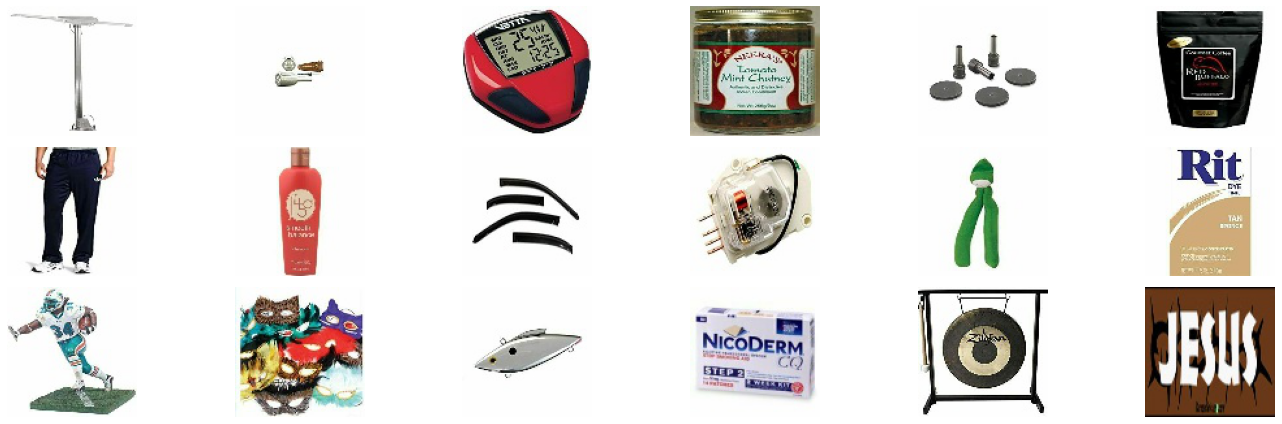

In [51]:
j = 1   # counter for loop iterations
rows = 3
columns = 6
stepsize = 42
fig = plt.subplots(rows, columns, figsize=(20,6))
for i in range(1,(rows*columns*stepsize),stepsize):
    plt.subplot(rows,columns,j)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image_list[i])
    j += 1

plt.tight_layout()
print('iterations: ', j-1)


# Read the data

Read  all the data(pictures and images) and bring them together. Also do some prefiltering of the text like mentioned in the chapter before and do some image preprocessing. 

In [52]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3 MB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 18.7 MB/s 
     |████████████████████████████████| 37.1 MB 1.3 MB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 1.2 MB 34.1 MB/s 
     |████████████████████████████████| 211 kB 52.7 MB/s 
     |████████████████████████████████| 352 kB 45.7 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 679 kB 32.3 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 


In [53]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

**Prameters**


In [54]:
train_images_path = 'retail-products-classification/train/train'
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = len(CATEGORIES)

In [55]:
downloaded_files = []
for file in os.listdir(train_images_path):
    if file.endswith(".jpg"):
        downloaded_files.append(file.replace(".jpg", ""))
print(len(downloaded_files))

42000


In [56]:
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

### Image Preprocessing

In [57]:
#Normalization
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

### Read Data
Read all the product images from the train folder and get corresponding description from the csv file. Data should labeled by its category. 

In [58]:
#Time: 2:48 min
corpus = []
images = []
labels = []
image_id = []
#get a list of all files in the directory
files = os.listdir(train_images_path)
random.shuffle(files)

#iterate trough every single image in the list files
for img in files:
    #get the id of the image by removing the .jpeg
    img_id = img.split('.')[0]
    #create the image(size 80x80, rgb, convert into array)
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            #read the data of the image in the row with the image id
            index = data[data['ImgId']==img_id].index.values[0]
            #write the data into row
            row = data.iloc[index , :]
            #family = category of the image
            family = row[3]
            #if the family of the products is in the define categories
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                #adds an item to the end of the list images
                images.append(img_array.astype('float32'))
                #get a list with all tokens (words) in the description and title, own prefiltering 
                token_list = filter_description(str(title) + ' ' + str(description))#changed
                #adds the words of the current token_list to the corpus (Textsammlung)
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
                image_id.append(index)
        except IndexError as error:
            print(error)

#converting
#corpus = alle Beschreibungen 
images = np.asarray(images)
labels = pd.get_dummies(labels).values  #on hot encoded labels
images = preprocess_input(images)

# Textclassification with BERT
The Textclassification with BERT, first was implemented sperately an was trained just on the descriptions.


**Parameters**


In [61]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE


## Create the Dataset Input for the Model

In [63]:
#Train test Split:
p = int((len(image_id)*80)/100)

#train data
train_data_raw = str(corpus[:p])
train_labels_onehot = labels[:p]
#test data
test_data_raw = str(corpus[p:])
test_labels_onehot = labels[p:]

print('train data:',len(train_data_raw))
print('train labels:',len(train_labels_onehot))
print('test data:',len(test_data_raw))
print('test_labels:',len(test_labels_onehot))

train data: 18240641
train labels: 33600
test data: 4444736
test_labels: 8400


In [62]:
#create a Dataset and prefetch it, to speed up the training
train_ds=tf.data.Dataset.from_tensor_slices((train_data_raw,train_labels_onehot))
train_ds= train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds=tf.data.Dataset.from_tensor_slices((test_data_raw,test_labels_onehot))
test_ds= test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(train_ds)
print(test_ds)

ValueError: ignored

**Used BERT-Modelle**
1. small bert L-4_H-512_A-8 (train fast accuracy on submission of 0,83 by 25 epoche)
2. bert_en_uncased_L-12_H-768_A-12 (trains slow 900 s per epoche)

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Test of the preprocessing

In [ ]:
text_test = ['Test how the toknizer works']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 3231 2129 1996 2000 2243 3490 6290 2573  102    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


you get 3 outputs from the preprocessing that a BERT model uses(`input_words_id`, `input_mask` and `input_type_ids`).

- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.


## Using the BERT model

Test of the Output of the BERT Model

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[-0.0183803  -0.37850648 -0.99400103 -0.77014625  0.23823375 -0.39146137
 -0.9362296  -0.07738747  0.26897046  0.13012485  0.42968434 -0.07535645]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.7954481   0.3189432   0.8392433  ...  0.60110945  0.07426973
  -0.03603262]
 [ 0.42496878  0.03157587  0.42851037 ... -0.24669728  0.4995292
  -0.24622902]
 [-0.53173995  0.4610917   0.37715864 ... -0.21323088  0.30793858
  -0.1667816 ]
 ...
 [ 0.35677397  0.29752842  0.9584494  ...  0.04351008  0.6358813
  -0.01326872]
 [ 0.10171216 -0.03071488  0.6843994  ...  0.13620639  0.19494367
  -0.51037097]
 [-0.0481307  -0.04270399  0.48860288 ...  0.19315049  0.29938465
  -0.396508  ]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. It's an embedding for the description
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. This as a contextual embedding for every token in the descriptions.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

## Define the model

very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing',trainable=False)
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') # Erster versuch war trainable true mein ich also alles trainierbar
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(256,activation='relu')(net)
  net = tf.keras.layers.Dense(21, activation='softmax')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.50258225 0.52851033 0.5061177  0.5112402  0.5101716  0.5096187
  0.5064184  0.52270377 0.51121885 0.5141265  0.5098128  0.50438577
  0.50308603 0.507375   0.51446337 0.52055055 0.5048188  0.50289303
  0.55056113 0.50315875 0.5059378 ]], shape=(1, 21), dtype=float32)


In [ ]:
classifier_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  41373185    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

### Model structure

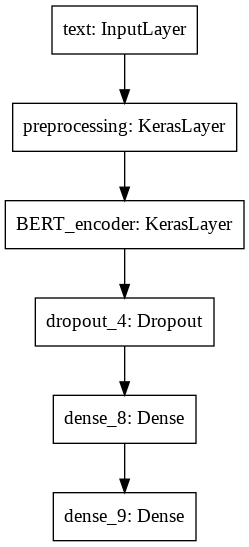

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training


### Loss function

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

### Optimizer

"Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
#trains ca. 300 s per epoche
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,epochs=epochs,validation_data=test_ds)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


525/525 [==============================] - 309s 569ms/step - loss: 2.0985 - categorical_accuracy: 0.3816 - val_loss: 1.0015 - val_categorical_accuracy: 0.6831
Epoch 2/10
525/525 [==============================] - 298s 568ms/step - loss: 0.8754 - categorical_accuracy: 0.7263 - val_loss: 0.7652 - val_categorical_accuracy: 0.7644
Epoch 3/10
525/525 [==============================] - 297s 566ms/step - loss: 0.6052 - categorical_accuracy: 0.8110 - val_loss: 0.7167 - val_categorical_accuracy: 0.7905
Epoch 4/10
525/525 [==============================] - 299s 569ms/step - loss: 0.4456 - categorical_accuracy: 0.8639 - val_loss: 0.7082 - val_categorical_accuracy: 0.8024
Epoch 5/10
525/525 [==============================] - 297s 566ms/step - loss: 0.3379 - categorical_accuracy: 0.8974 - val_loss: 0.6925 - val_categorical_accuracy: 0.8132
Epoch 6/10
 25/525 [>.............................] - ETA: 4:11 - loss: 0.3008 - categorical_accuracy: 0.9106

KeyboardInterrupt: ignored

In [ ]:
#save the model to colab
classifier_model.save("saved_model/weights.model_BERTsmall_l.h5")
#save the model to google drive
classifier_model.save("content/gdrive/model_BERTsmall_1.h5")
classifier_model.save_weights("content/gdrive/model_BERTsmall_1")


In [ ]:
#Load a model
model_loaded = keras.models.load_model('content/gdrive/')

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

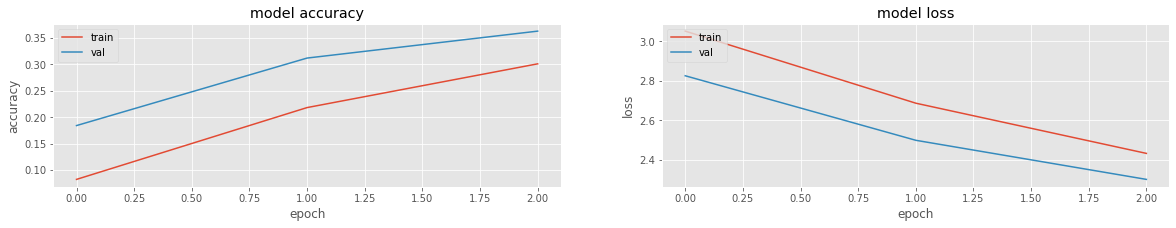

In [ ]:
history_bert = history.history
fig, axes = plt.subplots(1, 2, figsize=(20,3))

#Plot the accuracy
axes[0].plot(history_bert['categorical_accuracy'])
axes[0].plot(history_bert['val_categorical_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')


#Plot the loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')


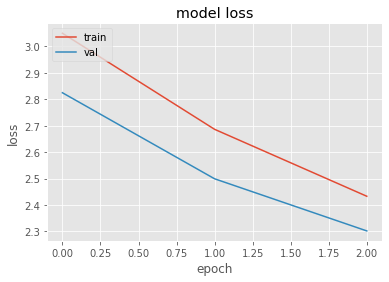

In [ ]:
#Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Submission only with use of the description

In [ ]:
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head(2)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5,B0000AZ6NS,"Sudbury Heavy Duty ELASTO Sealant, White, CART...","Elastomeric marine sealant. One part, fast ski..."
6,B0006IK268,Jacquard Textile Colors ruby red,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7,B000FNDZN6,Dylon Permanent Fabric Dye -Olive,Permanent Fabric Dye will not fade or wash awa...
8,B000GBO8UG,Fimo Soft Polymer Clay 2 Ounces-8020-70 Sahara,Fimo Soft Polymer Clay is easier to use than b...
9,B0006IK2FE,Jacquard Textile Colors yellow ochre,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [ ]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [ ]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(str(title) + ' ' + str(description))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

### create the input tensor

In [ ]:
del test_data_raw
del test_ds

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

#keine Ahnung was da passiert aber ohne den ganzen scheiß funzts ned, hab ich teilweise aus dem letzten laborversuch
test_ds_submission = tf.data.Dataset.from_tensor_slices(test_corpus)
test_ds_submission = test_ds_submission.batch(BATCH_SIZE)
test_ds_submission = test_ds_submission.cache().prefetch(buffer_size=AUTOTUNE)

Make prediction

In [ ]:
pred_submission = classifier_model.predict(test_ds_submission)
test_classes = np.argmax(pred_submission, axis = 1)
print(test_classes)
print(test_classes.shape)

[5 5 4 ... 0 7 0]
(6367,)


In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])

# Image Classification

In [ ]:
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras import layers
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D

## Preprocessing

### Train test split

In [ ]:
#Train test Split:
p = int((len(image_id)*80)/100)

train_image= images[:p]
train_labels_onehot = labels[:p]

test_image = images[p:]
test_labels_onehot = labels[p:]

print(len(train_image))
print(len(train_labels_onehot))

print(len(test_image))
print(len(test_labels_onehot))

33600
33600
8400
8400


## VGG 19

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import layers
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D

In [ ]:

input_tensor = Input(shape=INPUT_SHAPE)
model = VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor,
                 input_shape=(80, 80, 3), pooling=None,)
model.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
______________________________________________________________

In [ ]:
modelVGG = models.Sequential()                #add fully connected layer at the end of the pretrained model
modelVGG.add(model)
modelVGG.add(layers.Flatten())
modelVGG.add(layers.Dense(256, activation='relu'))
modelVGG.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.trainable = False
modelVGG.summary()

FINETUNE = 0    # set or reset FINETUNE#

# output = tf.keras.layers.Reshape((4096,))(modelVGG.output)
# outputVGG = tf.keras.layers.Dense(NUM_CLASSES, activation='relu')(output)
#modelVGG.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_6 (Dense)              (None, 21)                5397      
Total params: 20,554,325
Trainable params: 529,941
Non-trainable params: 20,024,384
_________________________________________________________________


### Fine tunening / transfer learning

In [ ]:
if FINETUNE:
  print('Finetuning the model...')
  # set the parameters, here only freeze blocks 1 to 4
  # The loop freezes all layers UP TO a specific one
  model.trainable = True
  set_trainable = False
  for layer in model.layers:
  # Replace according to your architecture...
    if layer.name == 'top_conv':           # For EfficientNetB7
    #if layer.name == 'block5_conv4':        # For VGG19
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

  modelVGG.summary() 

In [ ]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.01)
loss='categorical_crossentropy'
metric= m = tf.keras.metrics.CategoricalAccuracy()
modelVGG.compile(optimizer=optimizer, loss=loss, metrics =metric)

In [ ]:
history_img = modelVGG.fit(x=train_image,y=train_labels_onehot,validation_data=(test_image,test_labels_onehot),epochs=50)

Epoch 1/50
1050/1050 [==============================] - 15s 13ms/step - loss: 10.1148 - categorical_accuracy: 0.1009 - val_loss: 9.9826 - val_categorical_accuracy: 0.1439
Epoch 2/50
1050/1050 [==============================] - 13s 13ms/step - loss: 10.0527 - categorical_accuracy: 0.1383 - val_loss: 9.9618 - val_categorical_accuracy: 0.0589
Epoch 3/50
1050/1050 [==============================] - 14s 13ms/step - loss: 10.0146 - categorical_accuracy: 0.1416 - val_loss: 9.9123 - val_categorical_accuracy: 0.1250
Epoch 4/50
1050/1050 [==============================] - ETA: 0s - loss: 10.0170 - categorical_accuracy: 0.1473

KeyboardInterrupt: ignored

## Xception

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
print(input_tensor)
modelXcep = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor,
                input_shape=(80, 80, 3), pooling=None)
modelXcep.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 39, 39, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 39, 39, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 

In [ ]:
# freeze all parameters of the xception net
modelXcep.trainable = False

#add fully connected layer at the end of the pretrained model
modelXception = models.Sequential()                
modelXception.add(modelXcep)
modelXception.add(layers.Flatten())
modelXception.add(layers.Dense(2048,activation='relu'))
modelXception.add(layers.Dropout(0.2))
modelXception.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [ ]:
#add fully connected layer at the end of the pretrained model
modelXception = models.Sequential()                
modelXception.add(modelXcep)
modelXception.add(layers.Flatten())
modelXception.add(layers.Dense(1024,activation='relu'))
modelXception.add(layers.BatchNormalization())
modelXception.add(layers.Dense(256,activation='relu'))
modelXception.add(layers.BatchNormalization())
modelXception.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [ ]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.001)
loss='categorical_crossentropy'
metric= m = tf.keras.metrics.CategoricalAccuracy()

modelXception.compile(optimizer=optimizer, loss=loss, metrics=metric)

modelXception.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              37750784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 21)                43029     
Total params: 58,655,293
Trainable params: 37,793,813
Non-trainable params: 20,861,480
_________________________________________________________________


### Data Augumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=40,                                # value in degrees (0-180), a range within which to randomly rotate pictures
        width_shift_range=0.2, height_shift_range=0.2,    # are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
        rescale=1./255,                                   #by which we will multiply the data before any other processing
        shear_range=0.2,                                  #for randomly applying shearing transformations
        zoom_range=0.2,                                   #randomly zooming inside pictures
        horizontal_flip=True,
        vertical_flip=True,
        )

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_image)


In [ ]:
# fits the model on batches with real-time data augmentation:
history_img_Xception = modelXception.fit(datagen.flow(train_image, train_labels_onehot, batch_size=32),
                                          validation_data=(test_image, test_labels_onehot),
                                          epochs=300)

Epoch 1/300
1050/1050 [==============================] - 76s 70ms/step - loss: 3.1031 - categorical_accuracy: 0.0852 - val_loss: 2.8168 - val_categorical_accuracy: 0.1433
Epoch 2/300
1050/1050 [==============================] - 71s 68ms/step - loss: 2.8353 - categorical_accuracy: 0.1279 - val_loss: 2.7222 - val_categorical_accuracy: 0.1707
Epoch 3/300
1050/1050 [==============================] - 71s 68ms/step - loss: 2.8047 - categorical_accuracy: 0.1404 - val_loss: 2.7364 - val_categorical_accuracy: 0.1767
Epoch 4/300
1050/1050 [==============================] - 73s 70ms/step - loss: 2.7866 - categorical_accuracy: 0.1499 - val_loss: 2.6892 - val_categorical_accuracy: 0.1851
Epoch 5/300
1050/1050 [==============================] - 75s 72ms/step - loss: 2.7720 - categorical_accuracy: 0.1532 - val_loss: 2.6877 - val_categorical_accuracy: 0.1806
Epoch 6/300
1050/1050 [==============================] - 73s 69ms/step - loss: 2.7589 - categorical_accuracy: 0.1611 - val_loss: 2.6735 - val_cat

In [ ]:
modelXception.save_weights("saved_model/weights.model_Xception2")

### Training of the model

In [ ]:
#Transfer Learning
history_img_Xception = modelXception.fit(x=train_image,y=train_labels_onehot,validation_data=(test_image,test_labels_onehot),epochs=10, batch_size=32)



Epoch 1/10
1050/1050 [==============================] - 67s 20ms/step - loss: 2.4635 - categorical_accuracy: 0.2772 - val_loss: 2.3595 - val_categorical_accuracy: 0.2955
Epoch 2/10
1050/1050 [==============================] - 19s 18ms/step - loss: 2.1723 - categorical_accuracy: 0.3480 - val_loss: 2.2614 - val_categorical_accuracy: 0.3380
Epoch 3/10
1050/1050 [==============================] - 21s 20ms/step - loss: 2.0202 - categorical_accuracy: 0.3893 - val_loss: 2.2748 - val_categorical_accuracy: 0.3420
Epoch 4/10
1050/1050 [==============================] - 21s 20ms/step - loss: 1.8629 - categorical_accuracy: 0.4328 - val_loss: 2.2537 - val_categorical_accuracy: 0.3575
Epoch 5/10
1050/1050 [==============================] - 19s 18ms/step - loss: 1.7036 - categorical_accuracy: 0.4796 - val_loss: 2.3517 - val_categorical_accuracy: 0.3629
Epoch 6/10
1050/1050 [==============================] - 19s 18ms/step - loss: 1.5421 - categorical_accuracy: 0.5235 - val_loss: 2.3949 - val_categoric

In [ ]:
#Fine tunening
#Tune all parameters
modelXception.trainable = True
history_img_Xception = modelXception.fit(x=train_image,y=train_labels_onehot,validation_data=(test_image,test_labels_onehot),epochs=20,batch_size=32)

In [ ]:
modelXception.save_weights("saved_model/weights.model_Xception1")

## ResNet

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
print(input_tensor)
modelResNet152 = tf.keras.applications.resnet.ResNet152(
              include_top=False, weights='imagenet', input_tensor=input_tensor,
              input_shape=(80, 80, 3), pooling=None, classes=21)

# freeze all parameters of the xception net
modelResNet152.trainable = False
#modelResNet152.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 80, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
#add fully connected layer at the end of the pretrained model
modelResNet = models.Sequential()                
modelResNet.add(modelResNet152)
modelResNet.add(layers.Flatten())
modelResNet.add(layers.Dense(2048, activation='relu'))
#modelResNet.add(layers.BatchNormalization())
modelResNet.add(layers.Dropout(0.2))
#modelResNet.add(layers.Dense(512, activation='relu'))
#modelResNet.add(layers.BatchNormalization())
#modelResNet.add(layers.Dropout(0.2))
modelResNet.add(layers.Dense(NUM_CLASSES, activation='relu'))

Trainingversuche mit unterschieldichen AUfbau der letzten Layers un Ergebnisse:

In [ ]:
#one Fully connected Layer with 2048 parameters
# All parameters Trainable, Epochs = 10 , accuracy:0,96 val_accuracy:0,43, Adam 0.00003
# Only last layer Trainable,Epochs = 10, accuracy:0,6 val accuracy: 0,26, Adam 0.00003
modelResNet = models.Sequential()                
modelResNet.add(modelResNet152)
modelResNet.add(layers.Flatten())
modelResNet.add(layers.Dense(2048, activation='relu'))
#modelResNet.add(layers.BatchNormalization())
modelResNet.add(layers.Dropout(0.2))
modelResNet.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [ ]:
#For finetuning set to true --> All parameters are trainable
#modelResNet.trainable = True
#for fine tuneing set the learnrate very low --> 10^-5
optimizer= tf.keras.optimizers.Adam(0.00003)
loss='categorical_crossentropy'
metric= m = tf.keras.metrics.CategoricalAccuracy()

modelResNet.compile(optimizer=optimizer, loss=loss, metrics =metric)

modelResNet.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 3, 3, 2048)        58370944  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              37750784  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 21)                43029     
Total params: 96,164,757
Trainable params: 37,793,813
Non-trainable params: 58,370,944
_________________________________________________________________


### Data Augumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(train_image)


In [ ]:
# fits the model on batches with real-time data augmentation:
history_img_Xception = modelResNet.fit(datagen.flow(train_image, train_labels_onehot, batch_size=32),
                                          validation_data=(test_image, test_labels_onehot),
                                          epochs=5)

### Training of the model

In [ ]:
#Transfer Learning
history_img_ResNet = modelResNet.fit(x=train_image,y=train_labels_onehot,validation_data=(test_image,test_labels_onehot),epochs=10, batch_size=128)

Epoch 1/10
263/263 [==============================] - 97s 316ms/step - loss: 2.8019 - categorical_accuracy: 0.2583 - val_loss: 3.7960 - val_categorical_accuracy: 0.0526
Epoch 2/10
263/263 [==============================] - 81s 306ms/step - loss: 1.4326 - categorical_accuracy: 0.5749 - val_loss: 3.5121 - val_categorical_accuracy: 0.0863
Epoch 3/10
263/263 [==============================] - 81s 306ms/step - loss: 0.7381 - categorical_accuracy: 0.7942 - val_loss: 2.5943 - val_categorical_accuracy: 0.3020
Epoch 4/10
263/263 [==============================] - 81s 306ms/step - loss: 0.3711 - categorical_accuracy: 0.9107 - val_loss: 2.3444 - val_categorical_accuracy: 0.4262
Epoch 5/10
263/263 [==============================] - 85s 324ms/step - loss: 0.1904 - categorical_accuracy: 0.9611 - val_loss: 2.3403 - val_categorical_accuracy: 0.4388
Epoch 6/10
263/263 [==============================] - 81s 308ms/step - loss: 0.1082 - categorical_accuracy: 0.9809 - val_loss: 2.4964 - val_categorical_acc

In [ ]:
#Fine tuning
#Tune all parameters
modelResNet.trainable = True
history_img_ResNet = modelResNet.fit(x=train_image,y=train_labels_onehot,validation_data=(test_image,test_labels_onehot),epochs=10,batch_size=64)

Epoch 1/10
525/525 [==============================] - 45s 78ms/step - loss: 1.5071 - categorical_accuracy: 0.5751 - val_loss: 2.7908 - val_categorical_accuracy: 0.2410
Epoch 2/10
525/525 [==============================] - 41s 79ms/step - loss: 1.3359 - categorical_accuracy: 0.6279 - val_loss: 2.8618 - val_categorical_accuracy: 0.2451
Epoch 3/10
525/525 [==============================] - 40s 77ms/step - loss: 1.1892 - categorical_accuracy: 0.6723 - val_loss: 2.9694 - val_categorical_accuracy: 0.2424
Epoch 4/10
525/525 [==============================] - 40s 77ms/step - loss: 1.0583 - categorical_accuracy: 0.7154 - val_loss: 2.9964 - val_categorical_accuracy: 0.2486
Epoch 5/10
403/525 [======================>.......] - ETA: 7s - loss: 0.9372 - categorical_accuracy: 0.7525

KeyboardInterrupt: ignored

In [ ]:
modelResNet.save_weights("saved_model/weights.model_ResNet1")

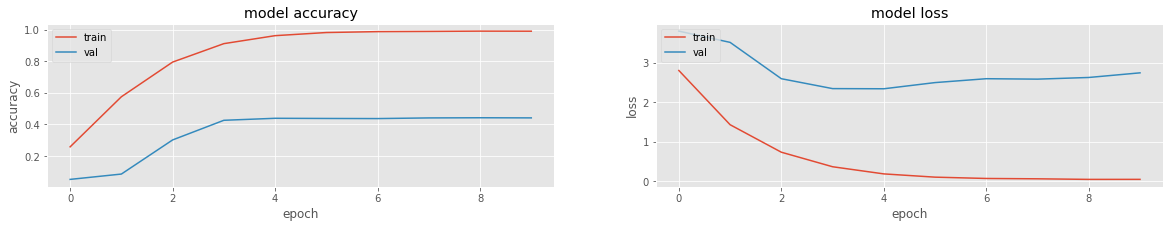

In [ ]:
history = history_img_ResNet.history
fig, axes = plt.subplots(1, 2, figsize=(20,3))

#Plot the accuracy
axes[0].plot(history['categorical_accuracy'])
axes[0].plot(history['val_categorical_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')


#Plot the loss
axes[1].plot(history['loss'])
axes[1].plot(history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')

# Put both models together

## Concatenate both models
Finally, we concatenate the output of both image and text classification model for interpretation and ultimate prediction. The functional API provided by Keras will help to build complex models with multiple output/input. We have used the Keras concatenate class to merge the result of both models. It takes a list of tensors, all are of the same shape as input and returns a single tensor which is the concatenation of all inputs. The concatenated output connects to the dense layer with softmax classifier. We have used the output layer to extract the embedding.

Bert + ResNet

In [ ]:
# Merge the text classifier and the CNN
merged = tf.keras.layers.Concatenate()([classifier_model.output,modelResNet.output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(100, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[classifier_model.input, modelResNet.input], outputs=output_layer)

Bert + Xception

In [ ]:
# Merge the text classifier and the CNN
merged = tf.keras.layers.Concatenate()([classifier_model.output,modelXception.output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(128, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[classifier_model.input, modelXception.input], outputs=output_layer)

In [ ]:
final_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
resnet152_input (InputLayer)    [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
resnet152 (Functional)          (None, 3, 3, 2048)   58370944    resnet152_input[0][0]            
____________________________________________________________________________________________

tf.keras.utils.plot_model(
    final_model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## Split the data into 80% training and 20% test

In [ ]:
#Split the data
p = int((len(images)*80)/100)

#Image Data
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]

#Text Data
BATCH_SIZE = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

train_data_raw = corpus[:p]
train_labels_onehot = labels[:p]
test_data_raw = corpus[p:]
test_labels_onehot = labels[p:]

text_train = np.asarray(train_data_raw)
text_test = np.asarray(test_data_raw)


NameError: ignored

In [ ]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)
print('Shape of train',text_train.shape)
print("Shape of Validation ",text_test.shape)

Shape of train (33600, 80, 80, 3)
Shape of Validation  (8400, 80, 80, 3)
Shape of train (33600, 21)
Shape of Validation  (8400, 21)
Shape of train (33600,)
Shape of Validation  (8400,)


## Data Augumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            #yield X2i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

In [ ]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
tensorboard = TensorBoard('./logs')
callbacks = [early_stop, reduce_lr, tensorboard]
adam = tf.keras.optimizers.Adam(learning_rate=1e-5)
#optimizer = adam
final_model.compile(optimizer = adam,
              loss='categorical_crossentropy',
              #metrics=['accuracy'])
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

#Precision : TP /(TP+FP)
#Recall: TP/(TP+FN)

## Train the model
During training on a supervised machine learning prediction task, the parameters of the neural network - the weights- are the embeddings will modify to minimize the loss.

In [ ]:
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 10
VALIDATION_SPLIT = .1
L2_REGULARIZATION = 0.01

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([text_train, image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test,image_test,], label_test))
except RuntimeError as e:
  print(e)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1050/1050 [==============================] - 320s 298ms/step - loss: 0.2211 - accuracy: 0.9641 - precision: 0.9799 - recall: 0.9504 - val_loss: 0.7312 - val_accuracy: 0.8280 - val_precision: 0.9644 - val_recall: 0.9374
Epoch 2/10
1050/1050 [==============================] - 308s 293ms/step - loss: 0.1822 - accuracy: 0.9715 - precision: 0.9612 - recall: 0.9340 - val_loss: 0.7572 - val_accuracy: 0.8244 - val_precision: 0.9575 - val_recall: 0.9382
Epoch 3/10
1050/1050 [==============================] - 304s 290ms/step - loss: 0.1527 - accuracy: 0.9768 - precision: 0.9544 - recall: 0.9400 - val_loss: 0.7738 - val_accuracy: 0.8265 - val_precision: 0.9543 - val_recall: 0.9407

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 4/10
1050/1050 [==============================] - 309s 294ms/step - loss: 0.1280 - accuracy: 0.9828 - precision: 0.9551 - recall: 0.9420 - val_loss: 0.7493 - val_accuracy: 0.8329 - val_precision: 0.9551 - val_recall: 0.9436
Epoch 5/10

In [ ]:
final_model.save_weights("saved_model/weights.BERTXception")
#final_model.load_weights("static/weights.h5")

 # **Make predictions on validation data**

In [ ]:
predictions = final_model.predict([text_test,image_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

8400/8400 - 125s


In [ ]:
accuracy_score(y_test, classes)

0.8351190476190476

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,classes)

Text(0.5, 114.0, 'Predicted label')

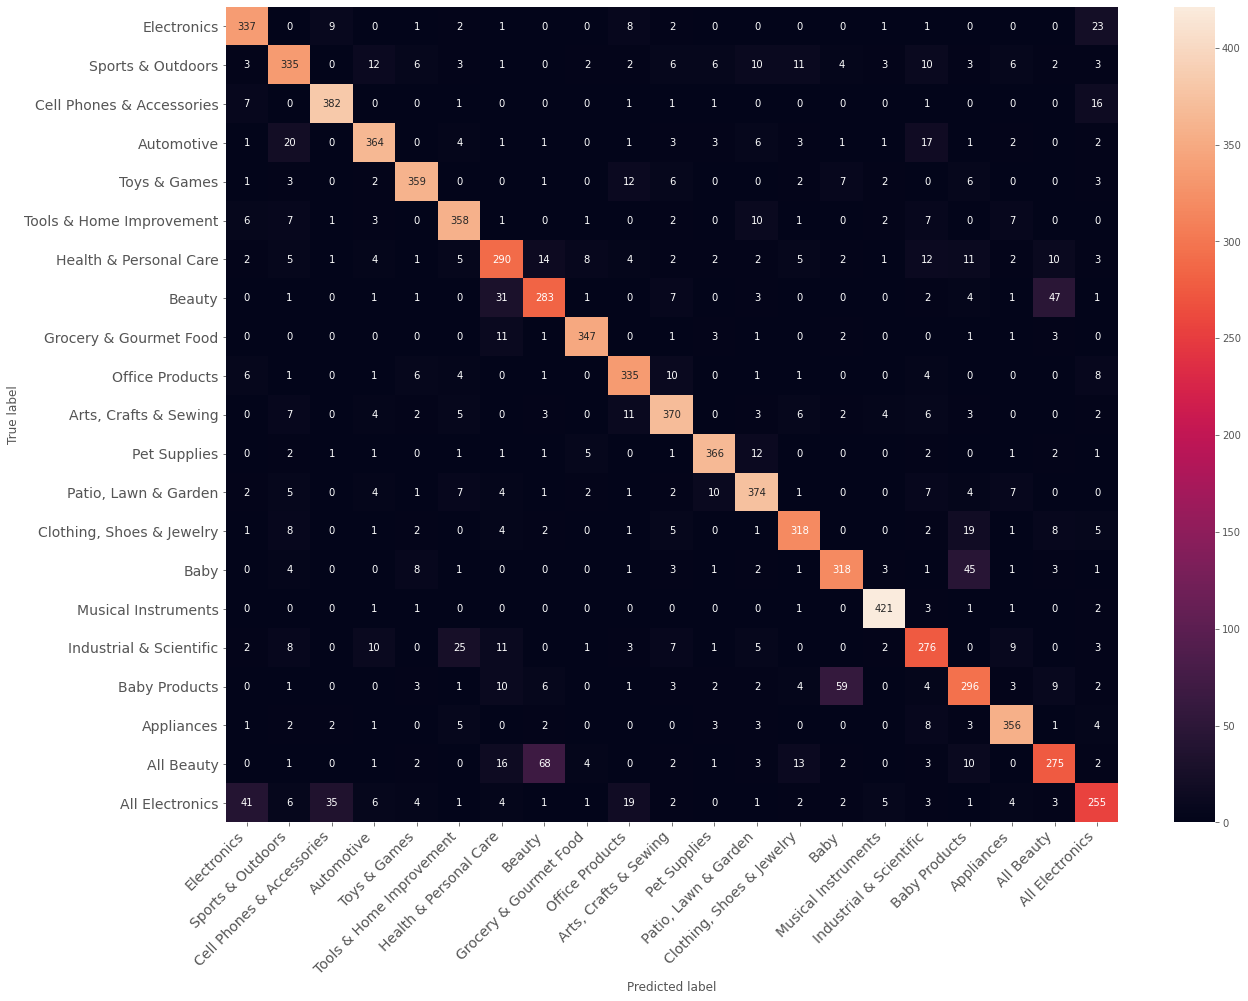

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

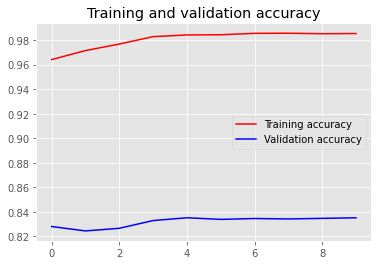

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

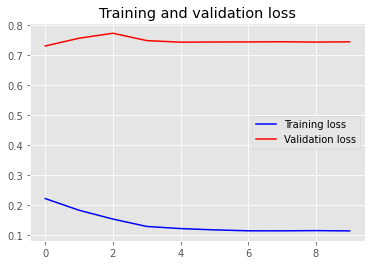

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Extract and visualize embedding

In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=final_model.input,
                                       outputs=final_model.layers[-1].output)
intermediate_output = intermediate_layer_model([image_train[:10000], text_train[:10000]])

y_train = np.argmax(label_train, axis = 1)
tsne_label = []
for i in range(10000):
    tsne_label.append(str(CATEGORIES[y_train[i]]))

UnimplementedError: ignored

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.manifold import TSNE
X = preprocessing.normalize(intermediate_output)
y = tsne_label
le = LabelEncoder()
y = le.fit_transform(y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

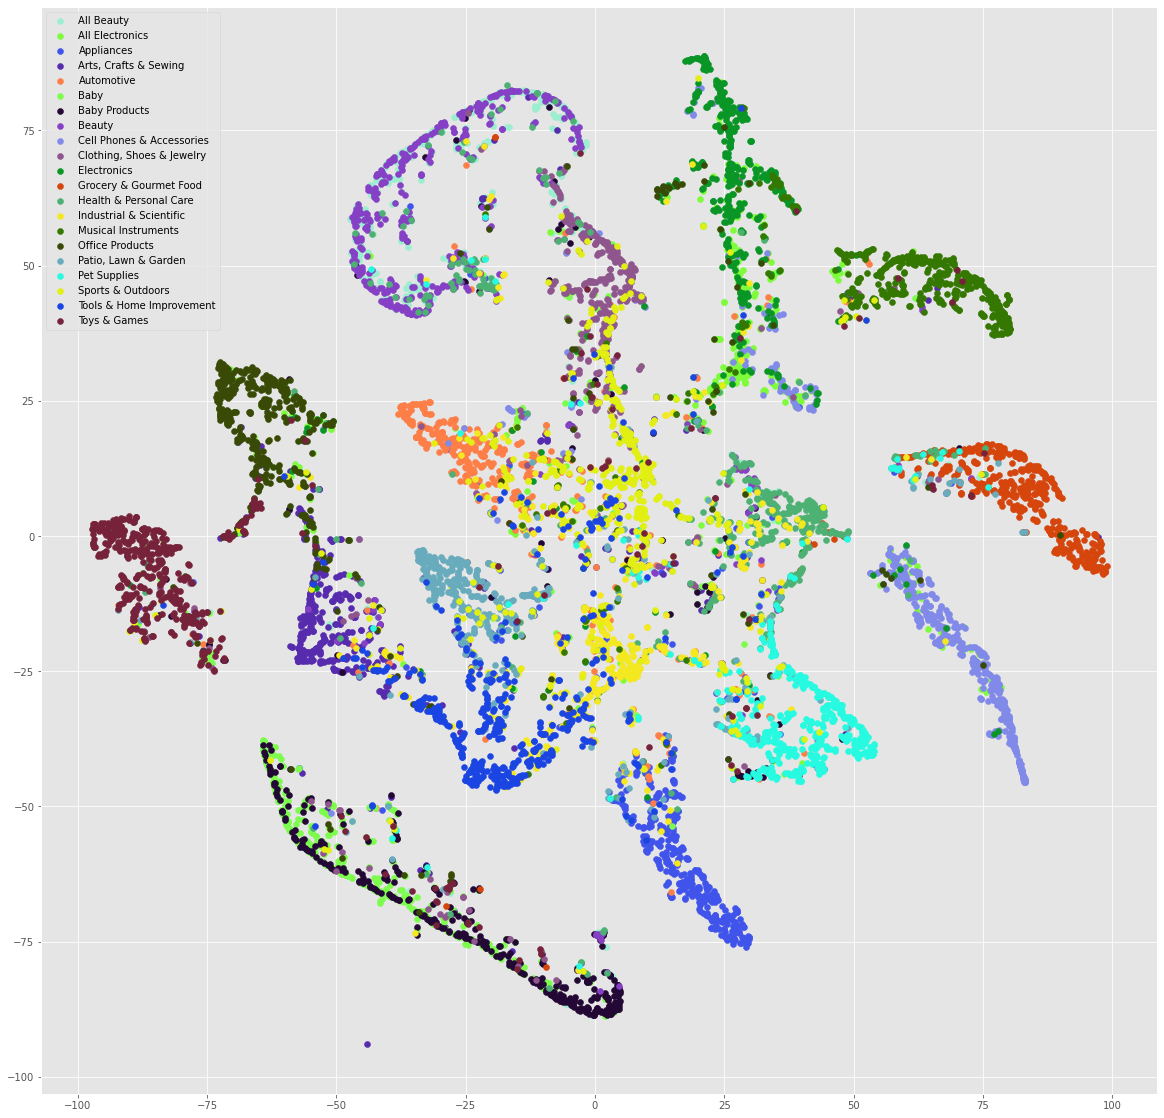

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
target_ids = range(len(le.classes_))

X_2d = tsne.fit_transform(X)

plt.figure(figsize=(20, 20))
for i, label in zip(target_ids, le.classes_):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=np.random.rand(3,), label=label)
plt.legend()
plt.show()

# Read the test data

In [ ]:
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head(10)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5,B0000AZ6NS,"Sudbury Heavy Duty ELASTO Sealant, White, CART...","Elastomeric marine sealant. One part, fast ski..."
6,B0006IK268,Jacquard Textile Colors ruby red,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7,B000FNDZN6,Dylon Permanent Fabric Dye -Olive,Permanent Fabric Dye will not fade or wash awa...
8,B000GBO8UG,Fimo Soft Polymer Clay 2 Ounces-8020-70 Sahara,Fimo Soft Polymer Clay is easier to use than b...
9,B0006IK2FE,Jacquard Textile Colors yellow ochre,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [ ]:
del image_train
del image_test
del label_train
del label_test
del text_train
del text_test
del images
del data

In [ ]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [ ]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            token_list = filter_description(str(title) + ' ' + str(description))#changed
            #adds the words of the current token_list to the corpus (Textsammlung)
            test_corpus.append(token_list)
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(corpus)
#sequences=tokenizer_obj.texts_to_sequences(corpus)
#tokenizer_obj=Tokenizer()
test_corpus = np.asarray(test_corpus)
test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

# **Make predictions on test data**

In [ ]:
pred = final_model.predict([test_corpus,test_images, ],batch_size=1,verbose = 2)
test_classes = np.argmax(pred, axis = 1)

6367/6367 - 97s


# Create submission file

In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.8 kB/s 
     |████████████████████████████████| 8.8 MB 27.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.2.0+cu92 which is incompatible.


In [ ]:
#Mount google drive to save the submission file there
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#save the weights to google drive
final_model.save_weights("content/gdrive/BERTXception1.h5")

In [ ]:
#create a submission file in google drive
!touch "/content/gdrive/My Drive/submission.csv"

In [ ]:
#write in the submission file of google drive
import csv
with open('/content/gdrive/My Drive/submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])